In [50]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg 
import os

In [51]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)


In [52]:
#calibrate the camera using objpoints and imgpoints
#gray will be last chessboard image
# calibrate only once
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [53]:
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [54]:
#plot the two images in a row
def plot_two_images(orig,output):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(orig)
    ax2.imshow(output, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

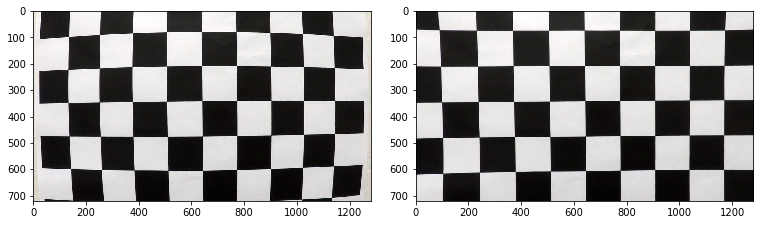

In [55]:
chessimg=mpimg.imread('./camera_cal/calibration1.jpg')
chess_undist=cal_undistort(chessimg)
# cv2.imwrite('./images/undist_calibration1.jpg',chess_undist)

plot_two_images(chessimg,chess_undist)

In [56]:
#threshold for one
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else: 
        sobel=cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        
    abs_sobel=np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag_grad=np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*mag_grad/np.max(mag_grad))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def color_threshold(image,sthresh=(0,255),vthresh=(0,255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
  
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel=hsv[:,:,2]

    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    c_binary=np.zeros_like(s_channel)
    c_binary[(s_binary == 1) & (v_binary == 1)] =1
    return c_binary

In [57]:
#calculate sliding window
def findlanelines(binary_warped,undist):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    global perform_sliding_window
    global left_fit
    global right_fit
    
    if perform_sliding_window == True:

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else :
        perform_sliding_window = False
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  



    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    return [ploty,left_fitx,right_fitx]


In [58]:
def visualize_img(warped,undist,Minv,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [59]:
global perform_sliding_window
perform_sliding_window=True
global left_fit
global right_fit

def process_image(image):
    #undistort the image
    undist=cal_undistort(image)

    #pre-process image - apply thresholds
    binary=np.zeros_like(undist[:,:,0])
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=3, thresh=(12, 255))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=3, thresh=(25, 255))
    c_binary=color_threshold(undist,(100,255),(50,255))
    binary[((gradx == 1) & (grady ==1) ) | (c_binary==1)]=255

    #perspective transform

    top_left = [560, 470]
    top_right = [730, 470]
    bottom_right = [1180, 720]
    bottom_left = [210, 720]
    src = np.float32([bottom_left, bottom_right,top_right,top_left])

    top_left_dst = [220,0]
    top_right_dst = [1100,0]
    bottom_right_dst = [1100,720]
    bottom_left_dst = [220,720]

    dst = np.float32([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst])
    M=cv2.getPerspectiveTransform(src,dst)
    Minv=cv2.getPerspectiveTransform(dst,src)
    
    img_size=(undist.shape[1],undist.shape[0])
    warped=cv2.warpPerspective(binary,M,img_size,flags=cv2.INTER_LINEAR)


    #calculate sliding window for one image
    #generate lane indices
    global perform_sliding_window
    
    [ploty,left_fitx,right_fitx] = findlanelines(warped,undist)
    result_img=visualize_img(warped,undist,Minv,ploty,left_fitx,right_fitx)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/970 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print('curvature',left_curverad, 'm', right_curverad, 'm')
    curverad=(left_curverad+right_curverad)/2

    text= 'Radius of Curvature = %.3f m'%(curverad)
    texted_image=cv2.putText(result_img, text , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    camera_center=(left_fitx[-1]+right_fitx[-1])/2
    center_diff=(camera_center-warped.shape[1]/2)*xm_per_pix
    side='left'
    if center_diff <= 0:
        side='right'

    lane_center_text=str(abs(round(center_diff,3)))+'m '+side+' of the center'
    texted_image=cv2.putText(result_img, lane_center_text , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return texted_image


In [60]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
white_output = './test_videos_output/project_video.mp4'

#create a output directory;
path=os.getcwd()+'/test_videos_output'
os.makedirs(path, exist_ok=True)

clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [04:17<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 4min 44s, sys: 50.2 s, total: 5min 35s
Wall time: 4min 19s
